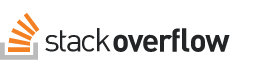

## [[link](https://stackoverflow.com/questions/65820541/how-to-download-g-suite-docs-sheets-to-pdf-xls-programatically)] How to Download G Suite docs/sheets to pdf/xls programatically?

I'm trying to download a Google doc to PDF or Sheet to XLS given an ID programmatically from the CLI.

Steps I've tried so far:

1. Contact support, but can't see a (?) help icon
1. Google for 10 minutes... I think Google Drive API does this (not sure)
1. Enable the [Google Drive API](https://developers.google.com/drive/api/v3/enable-drive-api)
1. Signed up for a GCP project
1. Navigated thought the UI to [enable the API](https://console.cloud.google.com/apis/library/drive.googleapis.com)
1. Trying the [GET API](https://developers.google.com/drive/api/v3/reference/about/get) results in 400 Invalid field selection using the fields for the ID of the document

I'm a bit stuck now and I am not sure how to proceed. Any suggestions?


## Answer Suggestion

### By Jayson Salazar

### [Twitter](https://twitter.com/jdsalaro) [LinkedIn](https://linkedin.com/in/jdsalaro) [Website](https://jdsalaro.com) 

---

In [1]:
# Install Python bindings for the Google API as per https://developers.google.com/drive/api/v3/quickstart/python

!pip3 install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [1]:
from googleapiclient.discovery import build
from google.oauth2 import service_account


since we're going to be exporting files via the google drive api, we need credentials for that scope as
detailed in https://developers.google.com/drive/api/v3/reference/files/export#auth

Choose an authentication method as detailed in https://developers.google.com/identity/protocols/oauth2#scenarios.

Since you mention creating a GCP project, I assume you're interested in using a GCP service account
as detailed in https://developers.google.com/identity/protocols/oauth2#serviceaccount

You can create a service account at https://console.developers.google.com/apis/credentials 
or as explained in https://developers.google.com/identity/protocols/oauth2/service-account#creatinganaccount

Make sure to enable domain-wide-delegation since you won't be able to impersonate other users, including
yourself and download their files.

In [ ]:
SCOPES = ['https://www.googleapis.com/auth/drive']

SERVICE_ACCOUNT_FILE = 'credentials.json'

# We use the SERVICE_ACCOUNT_FILE we just downloaded and the SCOPES we defined to create a Credentials object.
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# Remember, you must have created credentials.json with domain-wide delegation!
credentials = credentials.with_subject('user@example.com')

# We build a drive_v3 service using the credentials we just created
service = build('drive', 'v3', credentials=credentials)

We access the files resource as shown in https://developers.google.com/drive/api/v3/reference/files/get
and request the metadata of a file to which user@example.com has access:
https://docs.google.com/document/d/fileId/edit

In [2]:
files = service.files()
service.files().get(fileId='1U3eMevKxTwDxzvOBUsqa36zvwBzKPVYOFgy3k_9vxb8').execute()

{'kind': 'drive#file',
 'id': '1U3eMevKxTwDxzvOBUsqa36zvwBzKPVYOFgy3k_9vxb8',
 'name': 'empty',
 'mimeType': 'application/vnd.google-apps.document'}

We access the files resource again but this time to export the file as detailed in
https://developers.google.com/resources/api-libraries/documentation/drive/v3/python/latest/drive_v3.files.html#export
This could also be achieved using https://developers.google.com/drive/api/v3/manage-downloads.

Valid MIME types are listed in https://developers.google.com/drive/api/v3/ref-export-formats.

In [4]:
fconr = files.export(fileId='1U3eMevKxTwDxzvOBUsqa36zvwBzKPVYOFgy3k_9vxb8',
                     mimeType='application/vnd.openxmlformats-officedocument.wordprocessingml.document')

fcont = fconr.execute()

print('{}...'.format(fcont[:10]))

file = open("/tmp/sample.doc", "wb")
file.write(fcont)
file.close()

b'MN\xc30\x10\x85O\xc0\x1d"'...


As can be seen, `fcont` contains a binary blob that corresponds to the document and of which I'm showing the first 10 bytes. Finally, the blob is saved to `sample.doc`.

In [6]:
!ls -alh1 /tmp/sample.doc

-rw-rw-r-- 1 jdsalaro jdsalaro 6,0K Jan 20 23:38 /tmp/sample.doc
